In [1]:
from helper_functions import plot_all_cat_freq, remove_outliers
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Contexto
Como otimizar a operação de cobrança de débitos entre clientes dessas empresas de serviços?

#### *Hipótese 1*: Clientes com histórico de pagamentos pontuais são menos propensos a entrar em inadimplência no futuro.
Essa hipótese é fundamental para identificar os padrões de comportamento de pagamento dos clientes e segmentá-los com base em seu risco de inadimplência.

#### *Hipótese 2*: Clientes com dívidas mais elevadas têm uma probabilidade maior de inadimplência.
Essa hipótese pode fornecer insights valiosos sobre a relação entre o valor do débito e a probabilidade de inadimplência, ajudando a priorizar ações de cobrança para clientes com dívidas significativas.

#### *Hipótese 3*: Ações de cobrança mais assertivas e personalizadas têm maior probabilidade de sucesso.
A personalização das ações de cobrança com base no histórico de respostas dos clientes pode aumentar a efetividade e reduzir custos, tornando essa hipótese relevante para melhorar a abordagem de cobrança.

#### *Hipótese 4*: Diferença entre ação requerida e executada.
Investigar a discrepância entre o tipo de cobrança inicialmente requerido e o tipo de cobrança efetivamente executado pode fornecer insights sobre a adequação das ações propostas e a real resposta dos clientes.

#### *Hipótese 5*: A efetividade da cobrança pode variar conforme a categoria da ação.
Esta hipótese é relevante para entender se a agressividade das ações de cobrança influencia a probabilidade de recuperação do débito, auxiliando na escolha das categorias de ações mais adequadas para cada cliente.

In [2]:
df = pd.read_parquet('utilities_disconnection.parquet')

categorical = [
    'client_id',
    'regional', 
    'site', 
    'client_class', 
    'client_subclass', 
    'connection_type', 
    'connection_status', 
    'installment_status', 
    'disconnection_requested',
    'contractor_id',
    'disconnection_executed'
    ]

numerical = [
    'installment_value',
    'total_debt',
    'total_bills',
    ]

datetime = [
    'disconnection_date'
    ]

target = 'collected'

df[categorical] = df[categorical].astype('object')
for col in numerical:
    df[col] = df[col].astype(str).str.replace(",", ".").astype('float')
df[datetime] = df[datetime].apply(pd.to_datetime)
df[target] = df[target].astype(str).str.replace(",",".").astype('float')
df = df.drop_duplicates()
df['installment_status'] = df['installment_status'].fillna('N/A')

df.head()

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected
0,0,1,13414,1,7,single-phase connection,disconnected,252.39,complete,662.62,4.0,2017-03-06,circuit_break,"66,0",circuit_break,0.0
1,1,1,14071,1,1,single-phase connection,disconnected,0.00,N/A,1202.45,17.0,2017-03-31,circuit_break,"73,0",circuit_break,0.0
2,2,1,12380,1,1,biphasic connection,disconnected,0.00,N/A,352.56,1.0,2017-03-20,circuit_break,"20,0",circuit_break,0.0
3,3,1,14071,1,1,biphasic connection,disconnected,1317.25,complete,699.23,9.0,2017-03-29,pole,"73,0",pole,0.0
4,4,2,22212,1,1,biphasic connection,disconnected,2172.29,complete,484.10,4.0,2017-03-16,pole,"156,0",circuit_break,0.0


In [3]:
df.describe()

,installment_value,total_debt,total_bills,disconnection_date,collected
count,618204.000000,618204.00000,618204.000000,618204,618204.000000
mean,227.806475,401.39939,2.476364,2017-08-24 12:25:52.869926912,0.433661
min,0.000000,5.92000,1.000000,2017-03-01 00:00:00,0.000000
25%,0.000000,98.78000,1.000000,2017-05-18 00:00:00,0.000000
50%,0.000000,170.81000,1.000000,2017-08-22 00:00:00,0.000000
75%,247.970000,345.96250,2.000000,2017-11-29 00:00:00,1.000000
max,173855.100000,419092.78000,167.000000,2018-02-28 00:00:00,1.000000
std,769.866520,1795.41735,4.476651,NaN,0.495580


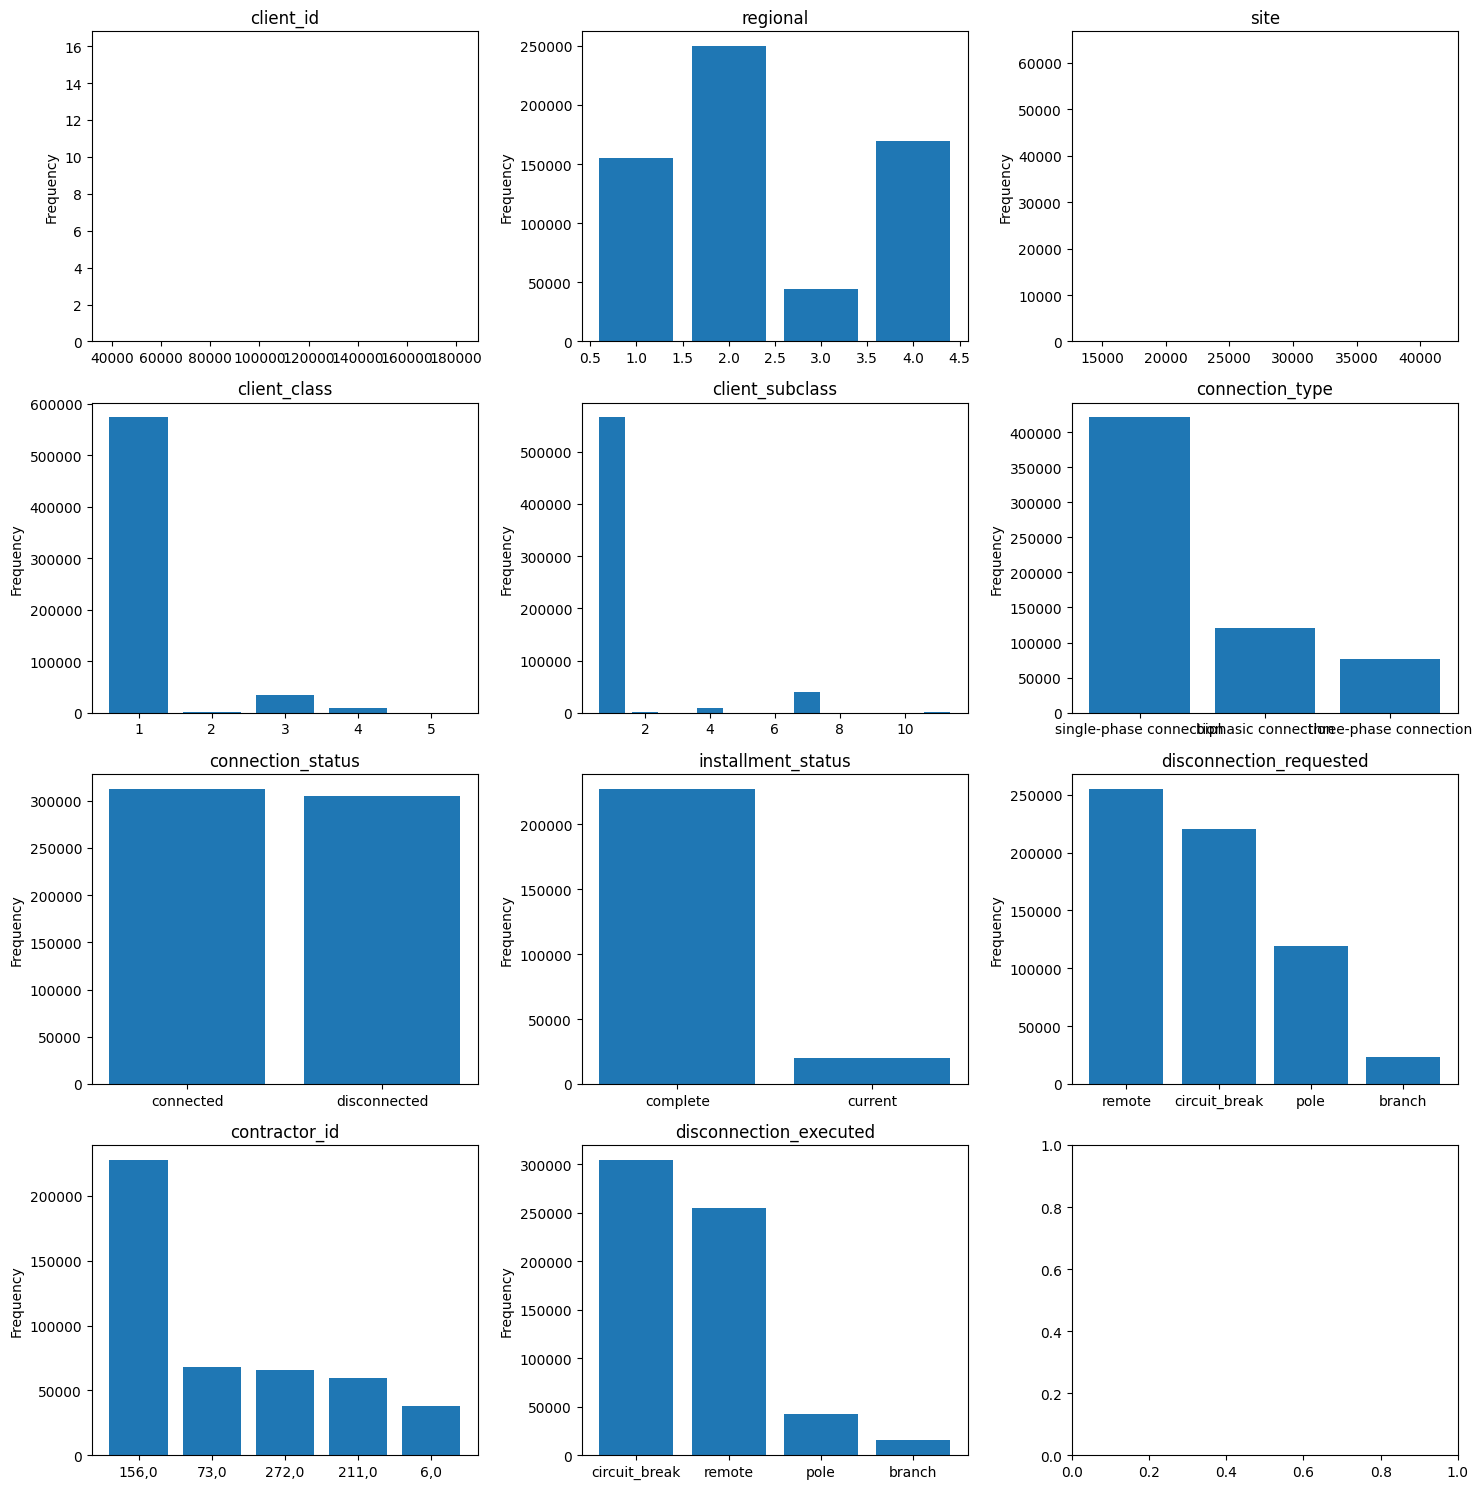

In [69]:
plot_all_cat_freq(df[categorical])

In [5]:
df.client_id.describe()

count     618346
unique    418463
top        49889
freq          22
Name: client_id, dtype: int64

Existem reincidentes!

Distribuição dos chamados

In [70]:
df_disc = df[['disconnection_date', 'client_id']].groupby(['disconnection_date']).count().resample('2W').sum()

<Axes: xlabel='disconnection_date'>

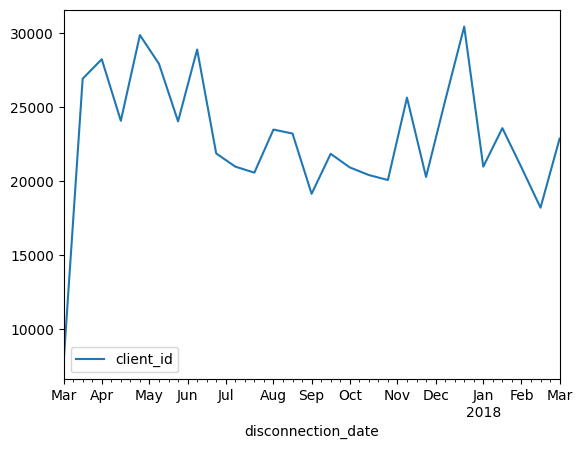

In [71]:
df_disc.plot()

Obs: O período é de 1 ano, então não é possível ver muitos padrões em relação ao mês ja que não se repetem

In [72]:
df.isna().sum()

client_id                       0
regional                        0
site                            0
client_class                    0
client_subclass                 0
connection_type                 0
connection_status               0
installment_value               0
installment_status         370736
total_debt                      0
total_bills                     0
disconnection_date              0
disconnection_requested         0
contractor_id                   0
disconnection_executed          0
collected                       0
dtype: int64

Esses valores NA são os "Não se aplica"

In [5]:
df['installment_status'] = df['installment_status'].fillna('N/A')

In [79]:
clients = [49889, 61993, 102061, 181679, 38622, 39037, 63640, 64579, 121980, 170146]
df.loc[df.client_id == clients[8]]

,client_id,regional,site,client_class,client_subclass,connection_type,connection_status,installment_value,installment_status,total_debt,total_bills,disconnection_date,disconnection_requested,contractor_id,disconnection_executed,collected
73546,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-04-06,pole,"73,0",circuit_break,0.0
116971,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-05-01,pole,"73,0",circuit_break,0.0
151573,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-05-17,pole,"73,0",circuit_break,0.0
160595,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-05-23,pole,"73,0",circuit_break,0.0
205609,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-06-14,pole,"73,0",circuit_break,0.0
206071,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-06-15,pole,"73,0",circuit_break,0.0
237899,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-07-06,pole,"73,0",circuit_break,0.0
242338,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-07-10,pole,"73,0",circuit_break,0.0
307576,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-08-19,pole,"73,0",circuit_break,0.0
331070,121980,1,14071,1,1,biphasic connection,disconnected,0.0,N/A,489.05,4.0,2017-09-05,pole,"73,0",pole,0.0


In [100]:
df.loc[:,['client_id','collected']].groupby(['client_id']).count().value_counts()

collected
1            297384
2             77569
3             25727
4              9771
5              3945
6              1794
7               920
8               570
9               344
10              201
11              114
12               77
13               26
14               10
15               10
16                1
Name: count, dtype: int64

In [66]:
df.loc[:,['client_id','collected']].groupby(['client_id']).mean().collected.apply(lambda x: 0 if x == 0 else 1 if x == 1 else 0.5).value_counts()/len(df.client_id.unique())

collected
0.0    0.510322
1.0    0.398876
0.5    0.090801
Name: count, dtype: float64

10% dos clientes fecham alguns, 90% ou sempre pagam os débitos ou nunca pagam, porém estamos contabilizando clientes com apenas uma requisição (que representa a maioria da base)

In [4]:
reincidentes = df.loc[:,['client_id','collected']].groupby(['client_id']).count()
reincidentes = list(reincidentes.loc[reincidentes.collected > 1].index)
df_re = df.loc[df.client_id.isin(reincidentes)].loc[:,['client_id','collected']]
df_re.groupby(['client_id']).mean().collected.apply(lambda x: 0 if x == 0 else 1 if x == 1 else 0.5).value_counts()/len(df_re.client_id.unique())

collected
0.0    0.412755
0.5    0.313820
1.0    0.273425
Name: count, dtype: float64

Entre os que possuíram mais de uma cobrança, existe um equilíbrio, o que indica que não há um padrão evidente no comportamento

<Axes: xlabel='total_debt', ylabel='Count'>

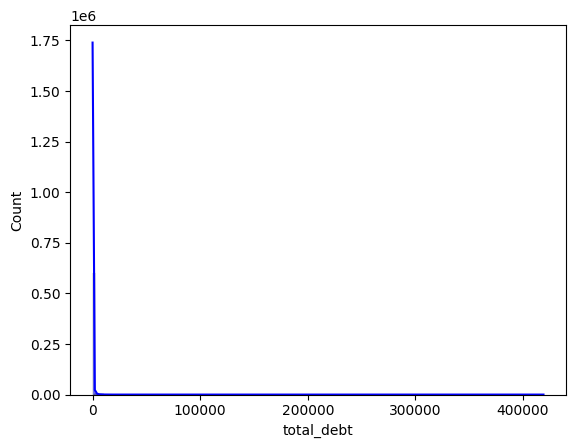

In [3]:
sns.histplot(data=df, x='total_debt', bins=200, kde=True, color='blue')

In [143]:
df[numerical].describe(percentiles = [0.25, 0.75, 0.9, 0.95, 0.99, 0.999])

,installment_value,total_debt,total_bills
count,618204.000000,618204.00000,618204.000000
mean,227.806475,401.39939,2.476364
std,769.866520,1795.41735,4.476651
min,0.000000,5.92000,1.000000
25%,0.000000,98.78000,1.000000
50%,0.000000,170.81000,1.000000
75%,247.970000,345.96250,2.000000
90%,593.560000,736.62000,5.000000
95%,1010.708500,1292.16000,8.000000
99%,2621.020000,3851.46380,21.000000


removendo valores acima de 99%

In [109]:
df = df.loc[df.total_debt < 3852].reset_index(drop = True)

<Axes: xlabel='total_debt', ylabel='Count'>

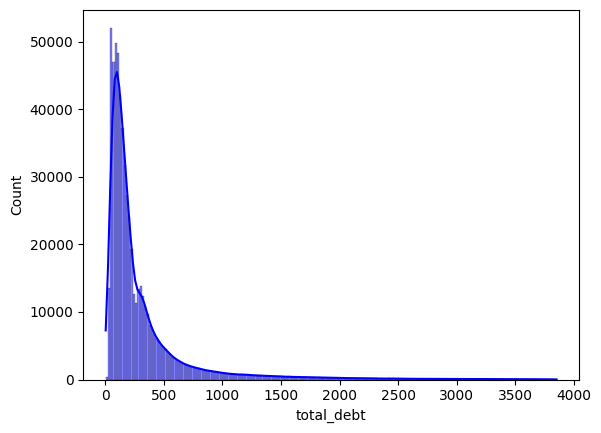

In [110]:
sns.histplot(data=df, x='total_debt', bins=200, kde=True, color='blue')

removendo valores acima de 500 para visualização

<Axes: xlabel='total_debt', ylabel='Count'>

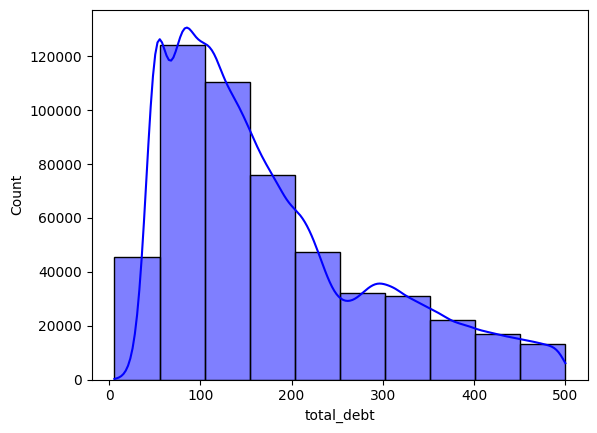

In [116]:
df_ate_500 = df.loc[df.total_debt < 500].reset_index(drop = True)
sns.histplot(data=df_ate_500, x='total_debt', bins=10, kde=True, color='blue')

In [114]:
print(f'Os valores de total_debt menores que 500 representam aproximadamente {df_ate_500.shape[0]/df.shape[0]*100:.2f}% da base')

Os valores de total_debt menores que 500 representam aproximadamente 84.82% da base


Removendo 99%

In [137]:
df_sem_out = df.loc[(df.installment_value < 2621)&(df.total_debt < 3852)&(df.total_bills < 21)]
df_sem_out.collected.describe()

count    602975.000000
mean          0.439753
std           0.496357
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: collected, dtype: float64

In [138]:
df_out = df.loc[~df.index.isin(df_sem_out.index)].reset_index(drop = True)
df_out.collected.describe()

count    15229.000000
mean         0.192462
std          0.394247
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: collected, dtype: float64

Removendo 95%

In [139]:
df_sem_out = df.loc[(df.installment_value < 1011)&(df.total_debt < 1292)&(df.total_bills < 21)]
df_sem_out.collected.describe()

count    563730.000000
mean          0.450217
std           0.497516
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: collected, dtype: float64

In [140]:
df_out = df.loc[~df.index.isin(df_sem_out.index)].reset_index(drop = True)
df_out.collected.describe()

count    54474.000000
mean         0.262327
std          0.439903
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: collected, dtype: float64

Removendo o IQR

In [145]:
IQR_installment_value = 247.970000 - 0.000000
IQR_total_debt = 345.96250 - 98.78000

LB_installment_value = 0
UB_installment_value = 247.970000 + IQR_installment_value  * 1.5

LB_total_debt = max(98.78000 - IQR_total_debt * 1.5, 0)
UB_total_debt = 345.96250 + IQR_total_debt  * 1.5

df_sem_out = df.loc[(df.installment_value < UB_installment_value)&(df.total_debt < UB_total_debt)]
df_sem_out.collected.describe()

count    516257.000000
mean          0.461096
std           0.498485
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: collected, dtype: float64

In [146]:
df_out = df.loc[~df.index.isin(df_sem_out.index)].reset_index(drop = True)
df_out.collected.describe()

count    101947.000000
mean          0.294732
std           0.455924
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: collected, dtype: float64

In [4]:
df_filtered = df.loc[df.index.isin(remove_outliers(df[['installment_value', 'total_debt']], bound_const=2))].reset_index(drop=True)
df_filtered.shape[0]/df.shape[0]

0.8652790988088075

<Axes: xlabel='total_debt', ylabel='Count'>

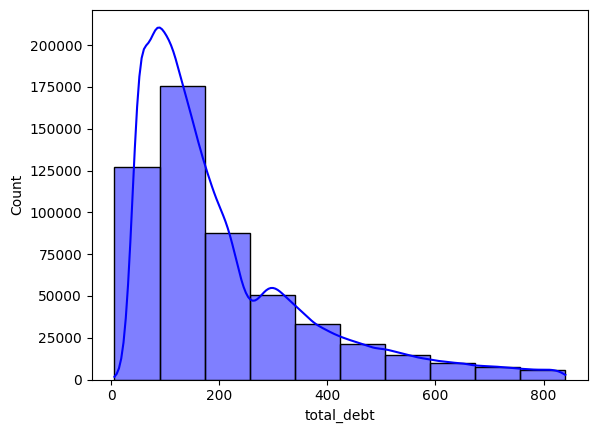

In [5]:
sns.histplot(data=df_filtered, x='total_debt', bins=10, kde=True, color='blue')

<Axes: xlabel='installment_value', ylabel='Count'>

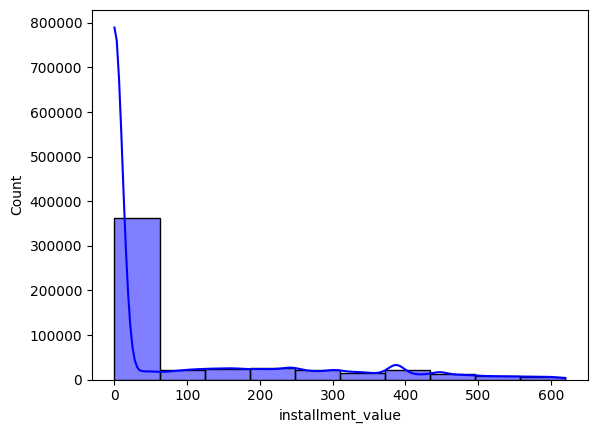

In [13]:
sns.histplot(data=df_filtered, x='installment_value', bins=10, kde=True, color='blue')

Analisando disconnection

In [16]:
df.loc[:,['disconnection_requested', 'disconnection_executed', 'collected']].groupby(['disconnection_requested', 'disconnection_executed']).count()

collected
disconnection_requested disconnection_executed           
branch                  branch                       3332
                        circuit_break               16188
                        pole                         4166
                        remote                          1
circuit_break           branch                       2198
                        circuit_break              207222
                        pole                        10774
                        remote                          8
pole                    branch                      10009
                        circuit_break               81390
                        pole                        27512
                        remote                          2
remote                  circuit_break                  15
                        pole                            2
                        remote                     255385

Normalmente, se é pedido circuit_break ou remote, é executado circuit_break ou remote.

In [19]:
df.loc[:,['disconnection_executed', 'collected']].groupby(['disconnection_executed']).agg(['mean','count','sum'])

collected                  
                            mean   count       sum
disconnection_executed                            
branch                  0.133857   15539    2080.0
circuit_break           0.333478  304815  101649.0
pole                    0.281128   42454   11935.0
remote                  0.596826  255396  152427.0

Apesar do aumento da agressividade, não se mostra tão eficiente

In [1]:
import pandas as pd
df_n = pd.read_csv('utilities_disconnection.csv',delimiter=";")
df_n.to_parquet('utilities_disconnection.parquet')

### Final

In [ ]:
# Step 1: Read the CSV file
def read_csv_file(file_path):
    data = pd.read_csv(file_path)
    return data

# Step 2: Preprocessing techniques
def preprocessing(data):
    # You can apply various preprocessing techniques here
    # For example, handling missing values, encoding categorical variables, etc.
    # For simplicity, let's assume the data is already preprocessed
    return data

# Step 3: Feature selection
def feature_selection(data, target_col, k=6):
    X = data.drop(columns=[target_col])
    y = data[target_col]
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    
    # You can comment why this method was chosen:
    # f_classif is used for classification tasks and SelectKBest selects the top k features
    # with the highest ANOVA F-value scores, indicating their relevance to the target variable.
    
    return data[selected_features], y

# Step 4: Separate the data into train, test, and validation sets
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Step 5: Test 3 machine learning models using cross-validation and hyperparameter tuning
def evaluate_models(X_train, y_train):
    models = {
        "Random Forest": RandomForestClassifier(),
        "Support Vector Machine": SVC(),
        "Logistic Regression": LogisticRegression()
    }
    
    best_models = {}
    for model_name, model in models.items():
        # Hyperparameter tuning using cross-validation
        param_grid = {}  # Add hyperparameters and their values for tuning
        grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
    
    return best_models

# Step 6: Evaluate the models on the validation dataset using 4 different metrics
def evaluate_on_validation(best_models, X_val, y_val):
    evaluation_results = {}
    metrics = {
        "Accuracy": accuracy_score,
        "Precision": precision_score,
        "Recall": recall_score,
        "F1 Score": f1_score
    }
    
    for model_name, model in best_models.items():
        model_metrics = {}
        for metric_name, metric_func in metrics.items():
            prediction = model.predict(X_val)
            score = metric_func(y_val, prediction)
            model_metrics[metric_name] = score
        evaluation_results[model_name] = model_metrics
    
    return evaluation_results

# Step 7: Save the prediction on the validation dataset in a CSV file
def save_predictions_to_csv(predictions, file_path):
    predictions.to_csv(file_path, index=False)

if __name__ == "__main__":
    # Step 1: Read the CSV file
    file_path = "path/to/your/csv/file.csv"
    data = read_csv_file(file_path)

    # Step 2: Preprocessing
    preprocessed_data = preprocessing(data)

    # Step 3: Feature selection
    target_col = "target_variable_name"
    selected_features, target = feature_selection(preprocessed_data, target_col)

    # Step 4: Split data into train, test, and validation sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(selected_features, target)

    # Step 5: Evaluate models using cross-validation and hyperparameter tuning
    best_models = evaluate_models(X_train, y_train)

    # Step 6: Evaluate models on the validation dataset
    evaluation_results = evaluate_on_validation(best_models, X_val, y_val)

    # Step 7: Save the prediction on the validation dataset in a CSV file
    validation_predictions = best_models["Best_Model"].predict(X_val)
    validation_data_with_predictions = X_val.copy()
    validation_data_with_predictions["predicted_target"] = validation_predictions
    save_predictions_to_csv(validation_data_with_predictions, "path/to/save/predictions.csv")
